## fine-tuning

In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from sklearn.utils import shuffle

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train2'
test_data_dir='data/test'

batch_size = 72   #19944/72=277  4986/72=69.25

#模型权重文件
model_h5file_base="InceptonResNetV2-base-tuning-v2.h5"
model_h5file_tunig1="InceptonResNetV2-fine-tuning-1-v2.h5"
model_h5file_tunig2="InceptonResNetV2-fine-tuning-2-v2.h5"
model_h5file_tunig3="InceptonResNetV2-fine-tuning-3-v2.h5"

#预测结果文件
pred_file_base="pred-InceptonResNetV2-base-tuning-v2.csv"
pred_file_tuning1="pred-InceptonResNetV2-fine-tuning-1-v2.csv"
pred_file_tuning2="pred-InceptonResNetV2-fine-tuning-2-v2.csv"
pred_file_tuning3="pred-InceptonResNetV2-fine-tuning-3-v2.csv"

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#构造InceptionResNetV2模型

x_input = Input((img_width, img_height, 3))
x_input = Lambda(inception_resnet_v2.preprocess_input)(x_input)

base_model = InceptionResNetV2(input_tensor=x_input, weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False
    
y = Dropout(0.25)(base_model.output)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)


In [ ]:
# 输出模型结构图
plot_model(model, to_file='model_InceptionResNetV2.png')

In [2]:
#生成训练、验证数据--全量读入内存
X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height, test=True)

X_train, Y_train=shuffle(X_train, Y_train)

  0%|          | 20/12479 [00:00<01:03, 195.90it/s]

dog_nums=12479, cat_nums=12451
total images: 498


  2%|▏         | 238/12451 [00:01<00:59, 206.98it/s]


In [4]:
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [10]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 299, 299, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation

Total params: 74,436,865
Trainable params: 54,277,729
Non-trainable params: 20,159,136
__________________________________________________________________________________________________


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [7]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]
epochs=10
history=model.fit(X_train, Y_train, batch_size=128, nb_epoch=epochs, validation_split=0.2)

Epoch 1/10
277/277 [==============================] - 616s 2s/step - loss: 0.5241 - acc: 0.7796 - val_loss: 0.2490 - val_acc: 0.9683

Epoch 00001: val_loss improved from inf to 0.24896, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 2/10
277/277 [==============================] - 526s 2s/step - loss: 0.3050 - acc: 0.9341 - val_loss: 0.1522 - val_acc: 0.9764

Epoch 00002: val_loss improved from 0.24896 to 0.15217, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 3/10
277/277 [==============================] - 528s 2s/step - loss: 0.2262 - acc: 0.9507 - val_loss: 0.1310 - val_acc: 0.9715

Epoch 00003: val_loss improved from 0.15217 to 0.13099, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 4/10
277/277 [==============================] - 528s 2s/step - loss: 0.1872 - acc: 0.9562 - val_loss: 0.1119 - val_acc: 0.9737

Epoch 00004: val_loss improved from 0.13099 to 0.11194, saving model to InceptonResNetV2-fine-tuning.h5
Epoch 5/10
277/277 [==============================] 

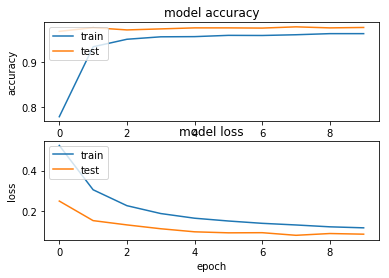

In [8]:
#可视化学习曲线

show_learning_curve(history)


In [11]:
#预测结果   
predict_on_model(12500, img_height, img_width, test_data_dir, model, filepath, pred_file_base)

100%|██████████| 12500/12500 [02:45<00:00, 75.44it/s]


12500/12500 [==============================] - 392s 31ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()
100%|██████████| 12500/12500 [00:00<00:00, 149553.87it/s]


## 冻结前698层，再训练
放开Inception-resnet-C第5个block之后的层，不含Inception-resnet-C_5  
698 block8_5_ac 

In [5]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=698)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [6]:
model.load_weights(model_h5file_base)

model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig1, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=5, 
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)

Epoch 1/5
277/277 [==============================] - 577s 2s/step - loss: 0.1216 - acc: 0.9609 - val_loss: 0.0741 - val_acc: 0.9814

Epoch 00001: val_loss improved from inf to 0.07407, saving model to InceptonResNetV2-fine-tuning-698.h5
Epoch 2/5
277/277 [==============================] - 407s 1s/step - loss: 0.1165 - acc: 0.9634 - val_loss: 0.0676 - val_acc: 0.9841

Epoch 00002: val_loss improved from 0.07407 to 0.06758, saving model to InceptonResNetV2-fine-tuning-698.h5
Epoch 3/5
277/277 [==============================] - 408s 1s/step - loss: 0.1096 - acc: 0.9655 - val_loss: 0.0654 - val_acc: 0.9851

Epoch 00003: val_loss improved from 0.06758 to 0.06536, saving model to InceptonResNetV2-fine-tuning-698.h5
Epoch 4/5
277/277 [==============================] - 407s 1s/step - loss: 0.1058 - acc: 0.9644 - val_loss: 0.0630 - val_acc: 0.9855

Epoch 00004: val_loss improved from 0.06536 to 0.06295, saving model to InceptonResNetV2-fine-tuning-698.h5
Epoch 5/5
277/277 [=====================

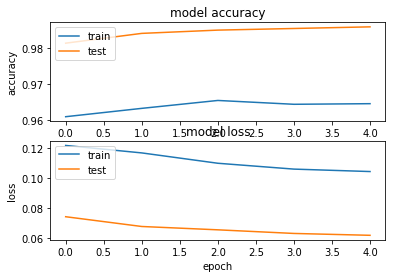

In [8]:
#可视化学习曲线
show_learning_curve(history)

In [10]:
#预测结果
predict_on_modle(12500, 299, 299, test_data_dir, model, model_h5file_tunig1, pred_file_tuning1)

100%|██████████| 12500/12500 [02:53<00:00, 72.11it/s]


12500/12500 [==============================] - 72s 6ms/step


NameError: name 'pd' is not defined

## 冻结前618层，再训练
放开Reduction-B之后的层，不含Reduction-B  
618 mixed_7a

In [ ]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=618)

In [ ]:
model.load_weights(model_h5file_tunig1)  #model_h5file_tunig1比base模型更好

model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig2, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=5, 
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)

In [ ]:
#预测结果
predict_on_model(12500, 299, 299, test_data_dir, model, model_h5file_tunig2, pred_file_tuning2)

## 冻结前499层，再训练
放开Inception-resnet-B 第17个block之后的层，不含包Inception-resnet-B_17  
499 block17_14_ac

In [ ]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=499)

In [ ]:
model.load_weights(filepath) #哪个模型好，加载哪个

model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig3, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
callbacks_list = [checkpoint]

history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples//batch_size,
        epochs=5, 
        validation_data=valid_generator,
        validation_steps=nb_validation_samples//batch_size,
        callbacks = callbacks_list)


In [ ]:
#预测结果
predict_on_model(12500, 299, 299, test_data_dir, model, model_h5file_tunig3, pred_file_tuning3)